# Follow-Me Project
Congratulations on reaching the final project of the Robotics Nanodegree! 

Previously, you worked on the Semantic Segmentation lab where you built a deep learning network that locates a particular human target within an image. For this project, you will utilize what you implemented and learned from that lab and extend it to train a deep learning model that will allow a simulated quadcopter to follow around the person that it detects! 

Most of the code below is similar to the lab with some minor modifications. You can start with your existing solution, and modify and improve upon it to train the best possible model for this task.

You can click on any of the following to quickly jump to that part of this notebook:
1. [Data Collection](#data)
2. [FCN Layers](#fcn)
3. [Build the Model](#build)
4. [Training](#training)
5. [Prediction](#prediction)
6. [Evaluation](#evaluation)

## Data Collection<a id='data'></a>
We have provided you with a starting dataset for this project. Download instructions can be found in the README for this project's repo.
Alternatively, you can collect additional data of your own to improve your model. Check out the "Collecting Data" section in the Project Lesson in the Classroom for more details!

In [1]:
import os
import glob
import sys
import tensorflow as tf

from scipy import misc
import numpy as np

from tensorflow.contrib.keras.python import keras
from tensorflow.contrib.keras.python.keras import layers, models

from tensorflow import image

from utils import scoring_utils
from utils.separable_conv2d import SeparableConv2DKeras, BilinearUpSampling2D
from utils import data_iterator
from utils import plotting_tools 
from utils import model_tools

## FCN Layers <a id='fcn'></a>
In the Classroom, we discussed the different layers that constitute a fully convolutional network (FCN). The following code will introduce you to the functions that you need to build your semantic segmentation model.

### Separable Convolutions
The Encoder for your FCN will essentially require separable convolution layers, due to their advantages as explained in the classroom. The 1x1 convolution layer in the FCN, however, is a regular convolution. Implementations for both are provided below for your use. Each includes batch normalization with the ReLU activation function applied to the layers. 

In [2]:
def separable_conv2d_batchnorm(input_layer, filters, strides=1):
    output_layer = SeparableConv2DKeras(filters=filters,kernel_size=3, strides=strides,
                             padding='same', activation='relu')(input_layer)
    
    output_layer = layers.BatchNormalization()(output_layer) 
    return output_layer

def conv2d_batchnorm(input_layer, filters, kernel_size=3, strides=1):
    output_layer = layers.Conv2D(filters=filters, kernel_size=kernel_size, strides=strides, 
                      padding='same', activation='relu')(input_layer)
    
    output_layer = layers.BatchNormalization()(output_layer) 
    return output_layer

### Bilinear Upsampling
The following helper function implements the bilinear upsampling layer. Upsampling by a factor of 2 is generally recommended, but you can try out different factors as well. Upsampling is used in the decoder block of the FCN.

In [3]:
def bilinear_upsample(input_layer):
    output_layer = BilinearUpSampling2D((2,2))(input_layer)
    return output_layer

## Build the Model <a id='build'></a>
In the following cells, you will build an FCN to train a model to detect and locate the hero target within an image. The steps are:
- Create an `encoder_block`
- Create a `decoder_block`
- Build the FCN consisting of encoder block(s), a 1x1 convolution, and decoder block(s).  This step requires experimentation with different numbers of layers and filter sizes to build your model.

### Encoder Block
Create an encoder block that includes a separable convolution layer using the `separable_conv2d_batchnorm()` function. The `filters` parameter defines the size or depth of the output layer. For example, 32 or 64. 

In [4]:
def encoder_block(input_layer, filters, strides):
    return separable_conv2d_batchnorm(input_layer, filters, strides)

### Decoder Block
The decoder block is comprised of three parts:
- A bilinear upsampling layer using the upsample_bilinear() function. The current recommended factor for upsampling is set to 2.
- A layer concatenation step. This step is similar to skip connections. You will concatenate the upsampled small_ip_layer and the large_ip_layer.
- Some (one or two) additional separable convolution layers to extract some more spatial information from prior layers.

In [5]:
def decoder_block(small_ip_layer, large_ip_layer, filters):
    upsampled = bilinear_upsample(small_ip_layer)
    merged = layers.concatenate([upsampled, large_ip_layer])    
    output_layer = separable_conv2d_batchnorm(merged, filters)    
    return output_layer

### Model

Now that you have the encoder and decoder blocks ready, go ahead and build your FCN architecture! 

There are three steps:
- Add encoder blocks to build the encoder layers. This is similar to how you added regular convolutional layers in your CNN lab.
- Add a 1x1 Convolution layer using the conv2d_batchnorm() function. Remember that 1x1 Convolutions require a kernel and stride of 1.
- Add decoder blocks for the decoder layers.

In [6]:
def fcn_model(inputs, num_classes):    
    # TODO Add Encoder Blocks. 
    # Remember that with each encoder layer, the depth of your model (the number of filters) increases.
    en1 = encoder_block(inputs, 128, 2)
    
    # TODO Add 1x1 Convolution layer using conv2d_batchnorm().
    cv1 = conv2d_batchnorm(en1, filters=64, kernel_size=1, strides=1)
    
    # TODO: Add the same number of Decoder Blocks as the number of Encoder Blocks
    dc1 = decoder_block(cv1, inputs, 128)
    x = dc1
    return layers.Conv2D(num_classes, 1, activation='softmax', padding='same')(x)

## Training <a id='training'></a>
The following cells will use the FCN you created and define an ouput layer based on the size of the processed image and the number of classes recognized. You will define the hyperparameters to compile and train your model.

Please Note: For this project, the helper code in `data_iterator.py` will resize the copter images to 160x160x3 to speed up training.

In [7]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""

image_hw = 160
image_shape = (image_hw, image_hw, 3)
inputs = layers.Input(image_shape)
num_classes = 3

# Call fcn_model()
output_layer = fcn_model(inputs, num_classes)

### Hyperparameters
Define and tune your hyperparameters.
- **batch_size**: number of training samples/images that get propagated through the network in a single pass.
- **num_epochs**: number of times the entire training dataset gets propagated through the network.
- **steps_per_epoch**: number of batches of training images that go through the network in 1 epoch. We have provided you with a default value. One recommended value to try would be based on the total number of images in training dataset divided by the batch_size.
- **validation_steps**: number of batches of validation images that go through the network in 1 epoch. This is similar to steps_per_epoch, except validation_steps is for the validation dataset. We have provided you with a default value for this as well.
- **workers**: maximum number of processes to spin up. This can affect your training speed and is dependent on your hardware. We have provided a recommended value to work with. 

In [8]:
learning_rate = 0.001
batch_size = 10
num_epochs = 100
steps_per_epoch = 200
validation_steps = 50
workers = 2

Epoch 1/100
199/200 [============================>.] - ETA: 0s - loss: 0.3676

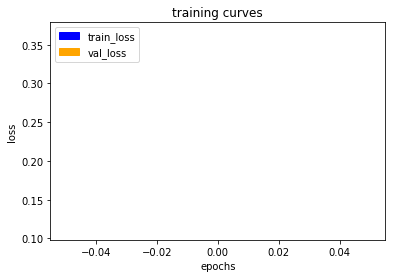

200/200 [==============================] - 46s - loss: 0.3661 - val_loss: 0.1111
Epoch 2/100
199/200 [============================>.] - ETA: 0s - loss: 0.0698

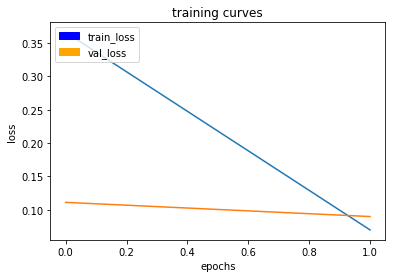

200/200 [==============================] - 45s - loss: 0.0697 - val_loss: 0.0898
Epoch 3/100
199/200 [============================>.] - ETA: 0s - loss: 0.0584

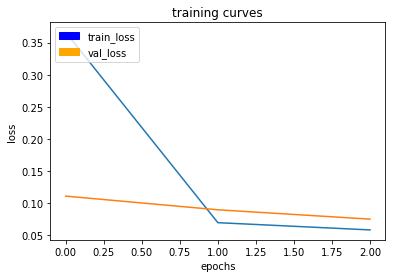

200/200 [==============================] - 49s - loss: 0.0584 - val_loss: 0.0753
Epoch 4/100
199/200 [============================>.] - ETA: 0s - loss: 0.0637

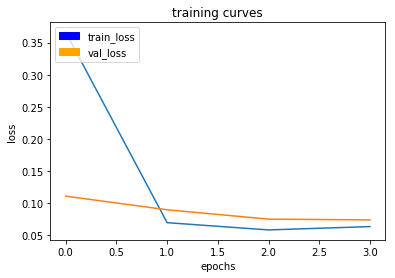

200/200 [==============================] - 48s - loss: 0.0636 - val_loss: 0.0741
Epoch 5/100
199/200 [============================>.] - ETA: 0s - loss: 0.0591

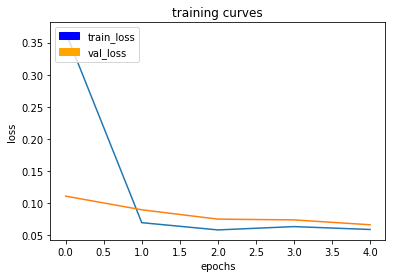

200/200 [==============================] - 44s - loss: 0.0590 - val_loss: 0.0665
Epoch 6/100
199/200 [============================>.] - ETA: 0s - loss: 0.0541

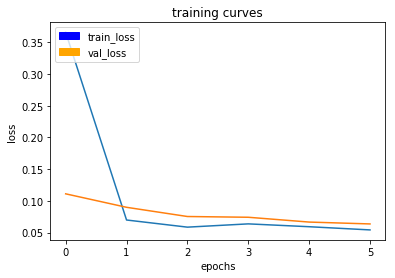

200/200 [==============================] - 44s - loss: 0.0541 - val_loss: 0.0635
Epoch 7/100
199/200 [============================>.] - ETA: 0s - loss: 0.0599

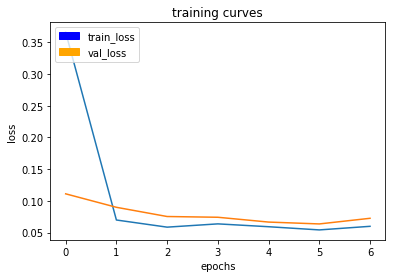

200/200 [==============================] - 44s - loss: 0.0597 - val_loss: 0.0724
Epoch 8/100
199/200 [============================>.] - ETA: 0s - loss: 0.0537

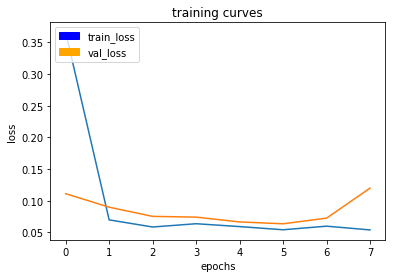

200/200 [==============================] - 44s - loss: 0.0539 - val_loss: 0.1199
Epoch 9/100
199/200 [============================>.] - ETA: 0s - loss: 0.0538

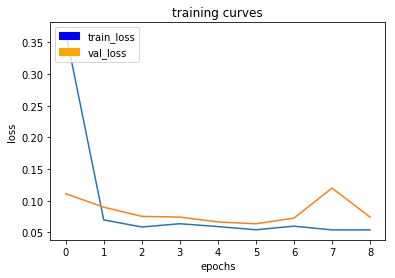

200/200 [==============================] - 44s - loss: 0.0538 - val_loss: 0.0742
Epoch 10/100
199/200 [============================>.] - ETA: 0s - loss: 0.0517

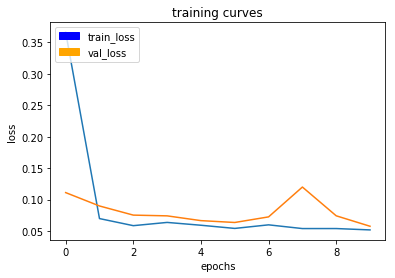

200/200 [==============================] - 44s - loss: 0.0517 - val_loss: 0.0575
Epoch 11/100
199/200 [============================>.] - ETA: 0s - loss: 0.0556

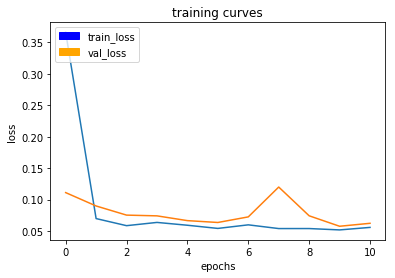

200/200 [==============================] - 44s - loss: 0.0555 - val_loss: 0.0622
Epoch 12/100
199/200 [============================>.] - ETA: 0s - loss: 0.0504

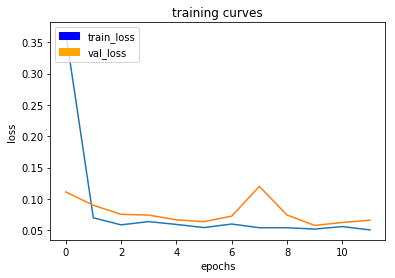

200/200 [==============================] - 44s - loss: 0.0504 - val_loss: 0.0659
Epoch 13/100
199/200 [============================>.] - ETA: 0s - loss: 0.0504

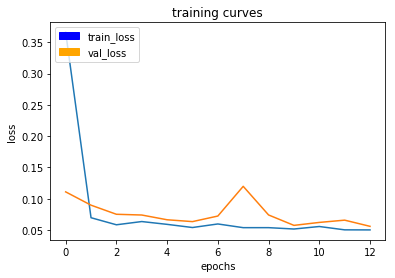

200/200 [==============================] - 44s - loss: 0.0504 - val_loss: 0.0560
Epoch 14/100
199/200 [============================>.] - ETA: 0s - loss: 0.0512

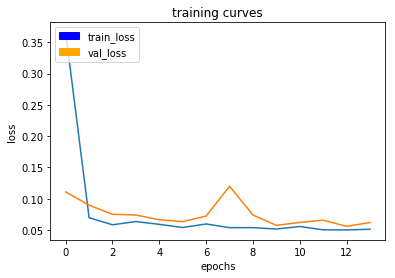

200/200 [==============================] - 44s - loss: 0.0513 - val_loss: 0.0621
Epoch 15/100
199/200 [============================>.] - ETA: 0s - loss: 0.0532

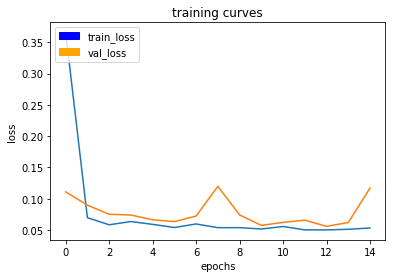

200/200 [==============================] - 44s - loss: 0.0532 - val_loss: 0.1173
Epoch 16/100
199/200 [============================>.] - ETA: 0s - loss: 0.0480

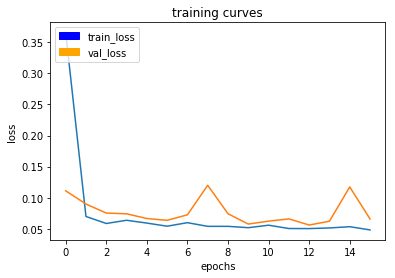

200/200 [==============================] - 44s - loss: 0.0481 - val_loss: 0.0657
Epoch 17/100
199/200 [============================>.] - ETA: 0s - loss: 0.0473

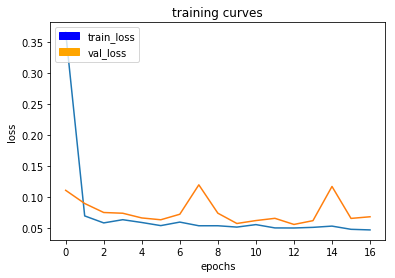

200/200 [==============================] - 44s - loss: 0.0472 - val_loss: 0.0684
Epoch 18/100
199/200 [============================>.] - ETA: 0s - loss: 0.0483

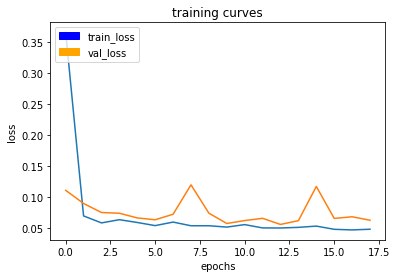

200/200 [==============================] - 44s - loss: 0.0483 - val_loss: 0.0628
Epoch 19/100
199/200 [============================>.] - ETA: 0s - loss: 0.0519

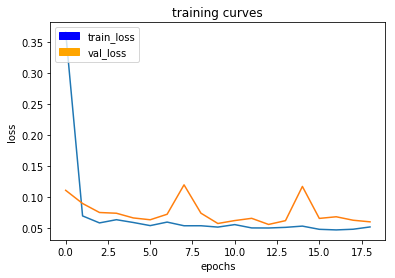

200/200 [==============================] - 44s - loss: 0.0519 - val_loss: 0.0602
Epoch 20/100
199/200 [============================>.] - ETA: 0s - loss: 0.0484

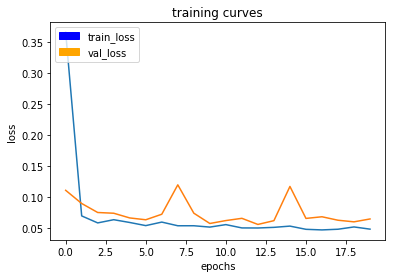

200/200 [==============================] - 44s - loss: 0.0484 - val_loss: 0.0648
Epoch 21/100
199/200 [============================>.] - ETA: 0s - loss: 0.0498

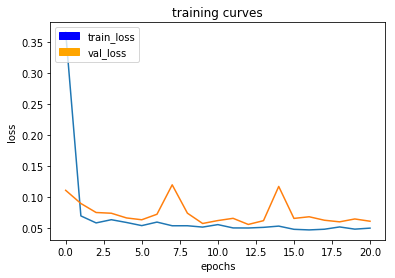

200/200 [==============================] - 44s - loss: 0.0501 - val_loss: 0.0612
Epoch 22/100
199/200 [============================>.] - ETA: 0s - loss: 0.0471

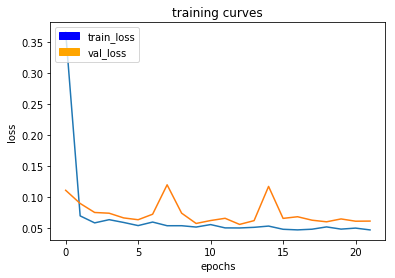

200/200 [==============================] - 44s - loss: 0.0471 - val_loss: 0.0614
Epoch 23/100
199/200 [============================>.] - ETA: 0s - loss: 0.0494

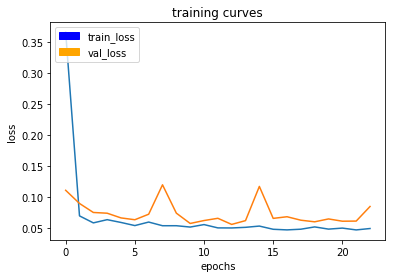

200/200 [==============================] - 44s - loss: 0.0494 - val_loss: 0.0849
Epoch 24/100
199/200 [============================>.] - ETA: 0s - loss: 0.0486

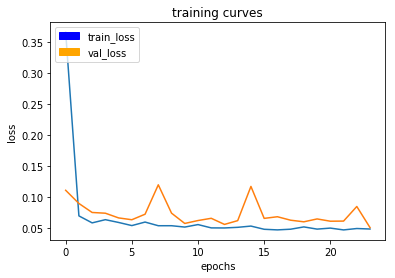

200/200 [==============================] - 44s - loss: 0.0486 - val_loss: 0.0508
Epoch 25/100
199/200 [============================>.] - ETA: 0s - loss: 0.0463

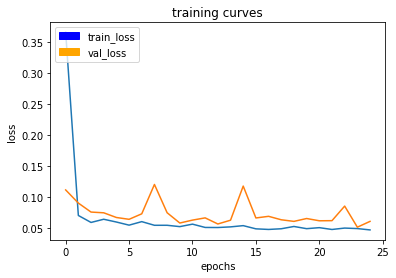

200/200 [==============================] - 44s - loss: 0.0463 - val_loss: 0.0602
Epoch 26/100
199/200 [============================>.] - ETA: 0s - loss: 0.0496

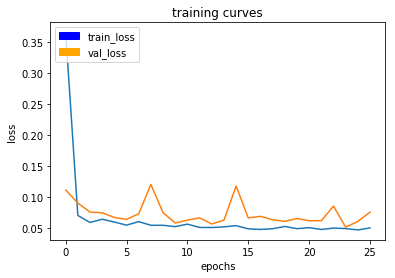

200/200 [==============================] - 44s - loss: 0.0496 - val_loss: 0.0751
Epoch 27/100
199/200 [============================>.] - ETA: 0s - loss: 0.0464

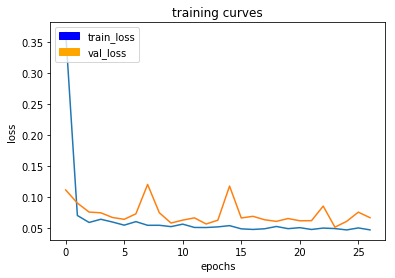

200/200 [==============================] - 44s - loss: 0.0463 - val_loss: 0.0661
Epoch 28/100
199/200 [============================>.] - ETA: 0s - loss: 0.0451

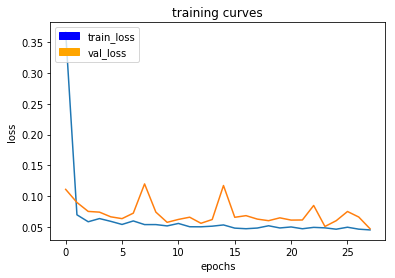

200/200 [==============================] - 44s - loss: 0.0452 - val_loss: 0.0471
Epoch 29/100
199/200 [============================>.] - ETA: 0s - loss: 0.0501

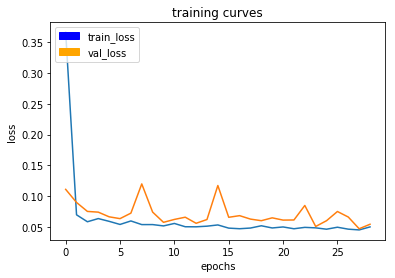

200/200 [==============================] - 44s - loss: 0.0500 - val_loss: 0.0544
Epoch 30/100
199/200 [============================>.] - ETA: 0s - loss: 0.0493

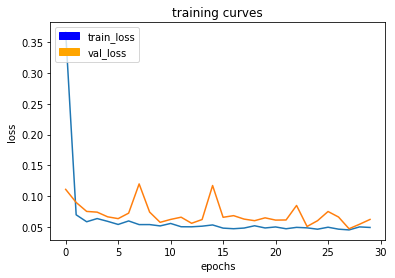

200/200 [==============================] - 44s - loss: 0.0492 - val_loss: 0.0622
Epoch 31/100
199/200 [============================>.] - ETA: 0s - loss: 0.0451

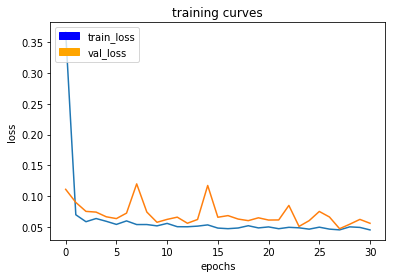

200/200 [==============================] - 44s - loss: 0.0451 - val_loss: 0.0559
Epoch 32/100
199/200 [============================>.] - ETA: 0s - loss: 0.0476

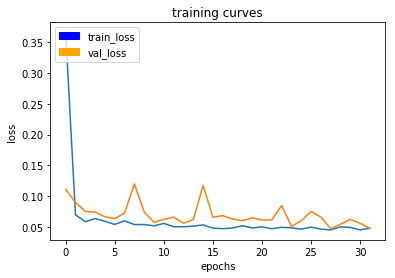

200/200 [==============================] - 44s - loss: 0.0477 - val_loss: 0.0473
Epoch 33/100
199/200 [============================>.] - ETA: 0s - loss: 0.0447

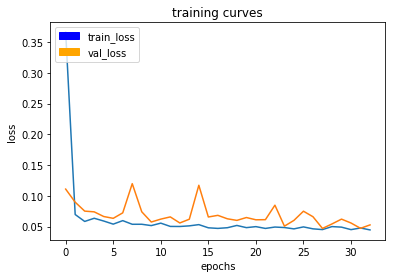

200/200 [==============================] - 44s - loss: 0.0447 - val_loss: 0.0529
Epoch 34/100
199/200 [============================>.] - ETA: 0s - loss: 0.0421

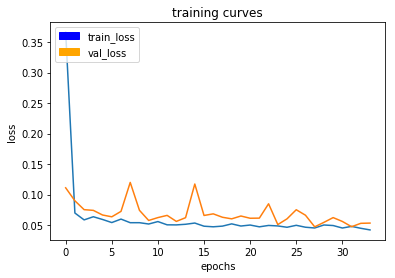

200/200 [==============================] - 44s - loss: 0.0422 - val_loss: 0.0532
Epoch 35/100
199/200 [============================>.] - ETA: 0s - loss: 0.0513

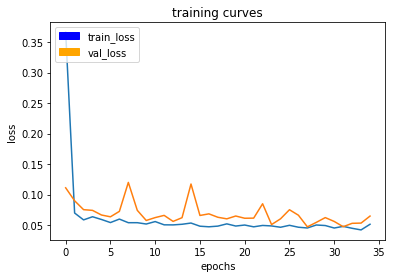

200/200 [==============================] - 44s - loss: 0.0513 - val_loss: 0.0647
Epoch 36/100
199/200 [============================>.] - ETA: 0s - loss: 0.0464

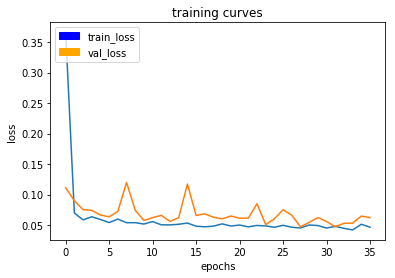

200/200 [==============================] - 44s - loss: 0.0464 - val_loss: 0.0622
Epoch 37/100
199/200 [============================>.] - ETA: 0s - loss: 0.0448

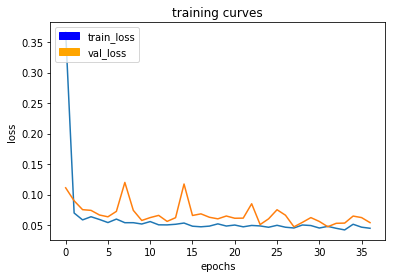

200/200 [==============================] - 44s - loss: 0.0447 - val_loss: 0.0540
Epoch 38/100
199/200 [============================>.] - ETA: 0s - loss: 0.0467

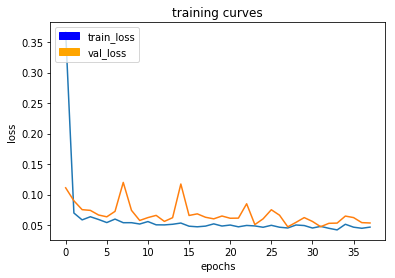

200/200 [==============================] - 44s - loss: 0.0467 - val_loss: 0.0534
Epoch 39/100
199/200 [============================>.] - ETA: 0s - loss: 0.0455

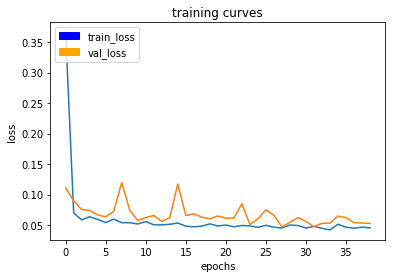

200/200 [==============================] - 44s - loss: 0.0454 - val_loss: 0.0526
Epoch 40/100
199/200 [============================>.] - ETA: 0s - loss: 0.0479

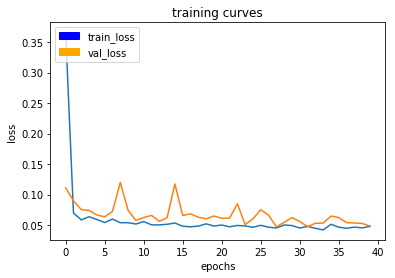

200/200 [==============================] - 44s - loss: 0.0480 - val_loss: 0.0484
Epoch 41/100
199/200 [============================>.] - ETA: 0s - loss: 0.0420

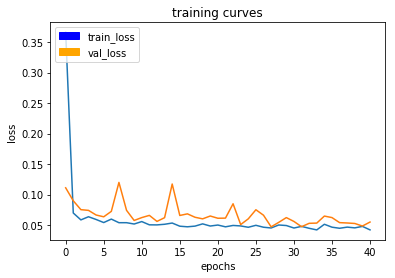

200/200 [==============================] - 44s - loss: 0.0421 - val_loss: 0.0549
Epoch 42/100
199/200 [============================>.] - ETA: 0s - loss: 0.0422

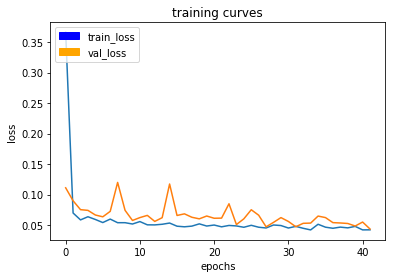

200/200 [==============================] - 44s - loss: 0.0421 - val_loss: 0.0435
Epoch 43/100
199/200 [============================>.] - ETA: 0s - loss: 0.0466

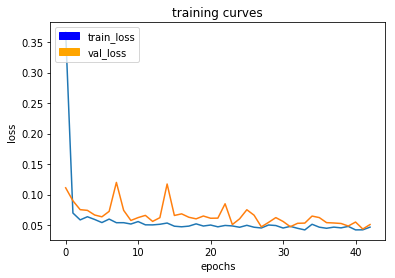

200/200 [==============================] - 44s - loss: 0.0466 - val_loss: 0.0508
Epoch 44/100
199/200 [============================>.] - ETA: 0s - loss: 0.0431

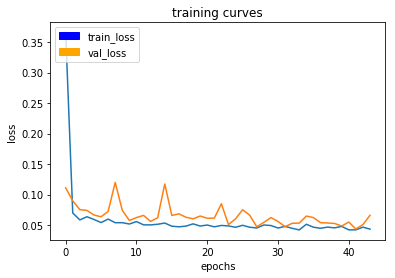

200/200 [==============================] - 44s - loss: 0.0432 - val_loss: 0.0661
Epoch 45/100
199/200 [============================>.] - ETA: 0s - loss: 0.0475

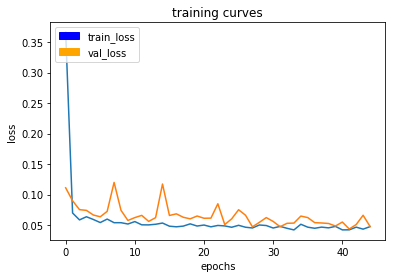

200/200 [==============================] - 44s - loss: 0.0474 - val_loss: 0.0477
Epoch 46/100
199/200 [============================>.] - ETA: 0s - loss: 0.0428

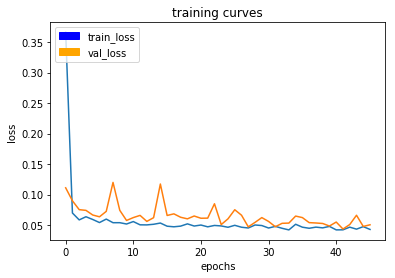

200/200 [==============================] - 44s - loss: 0.0427 - val_loss: 0.0504
Epoch 47/100
199/200 [============================>.] - ETA: 0s - loss: 0.0419

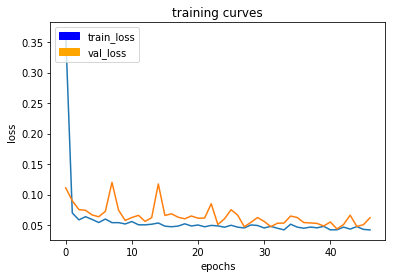

200/200 [==============================] - 44s - loss: 0.0420 - val_loss: 0.0620
Epoch 48/100
199/200 [============================>.] - ETA: 0s - loss: 0.0447

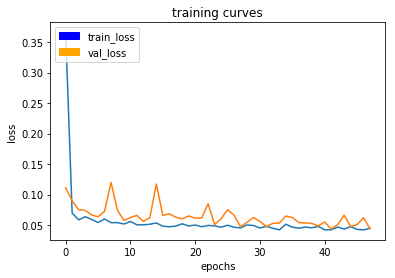

200/200 [==============================] - 44s - loss: 0.0447 - val_loss: 0.0438
Epoch 49/100
199/200 [============================>.] - ETA: 0s - loss: 0.0426

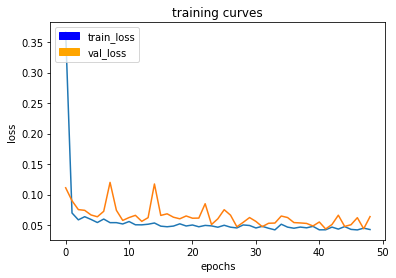

200/200 [==============================] - 44s - loss: 0.0426 - val_loss: 0.0638
Epoch 50/100
199/200 [============================>.] - ETA: 0s - loss: 0.0477

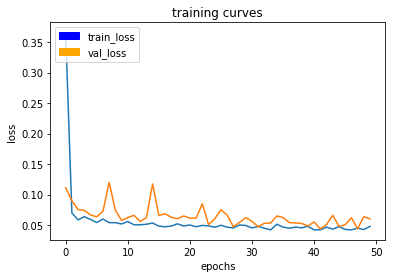

200/200 [==============================] - 44s - loss: 0.0477 - val_loss: 0.0601
Epoch 51/100
199/200 [============================>.] - ETA: 0s - loss: 0.0419

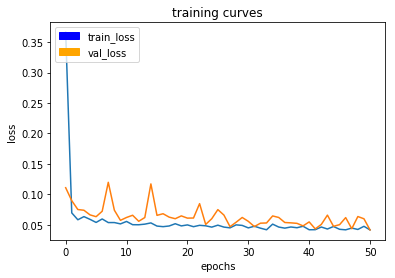

200/200 [==============================] - 44s - loss: 0.0419 - val_loss: 0.0418
Epoch 52/100
199/200 [============================>.] - ETA: 0s - loss: 0.0433

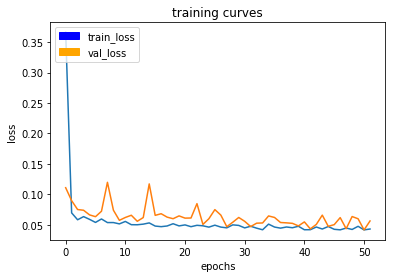

200/200 [==============================] - 44s - loss: 0.0432 - val_loss: 0.0565
Epoch 53/100
199/200 [============================>.] - ETA: 0s - loss: 0.0454

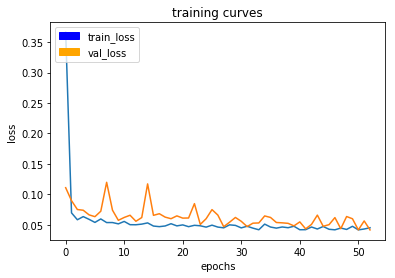

200/200 [==============================] - 44s - loss: 0.0453 - val_loss: 0.0418
Epoch 54/100
199/200 [============================>.] - ETA: 0s - loss: 0.0419

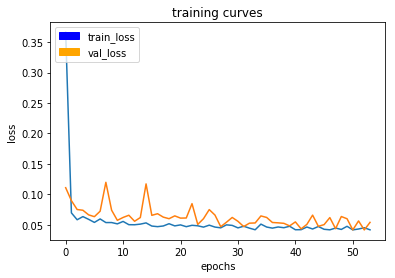

200/200 [==============================] - 44s - loss: 0.0418 - val_loss: 0.0542
Epoch 55/100
199/200 [============================>.] - ETA: 0s - loss: 0.0432

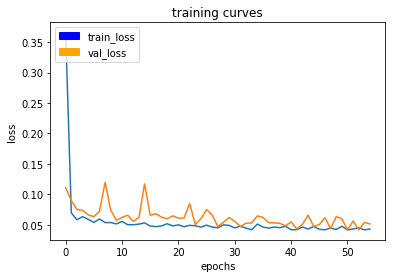

200/200 [==============================] - 44s - loss: 0.0432 - val_loss: 0.0516
Epoch 56/100
199/200 [============================>.] - ETA: 0s - loss: 0.0428

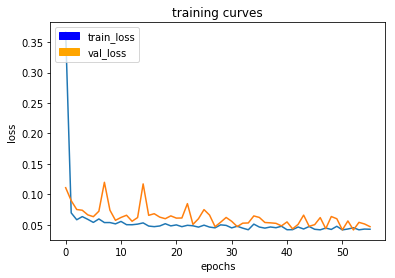

200/200 [==============================] - 44s - loss: 0.0428 - val_loss: 0.0471
Epoch 57/100
199/200 [============================>.] - ETA: 0s - loss: 0.0447

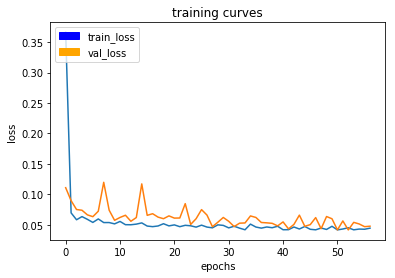

200/200 [==============================] - 44s - loss: 0.0447 - val_loss: 0.0479
Epoch 58/100
199/200 [============================>.] - ETA: 0s - loss: 0.0407

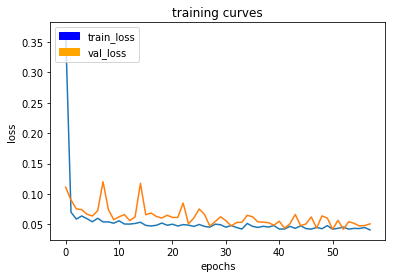

200/200 [==============================] - 44s - loss: 0.0407 - val_loss: 0.0507
Epoch 59/100
199/200 [============================>.] - ETA: 0s - loss: 0.0419

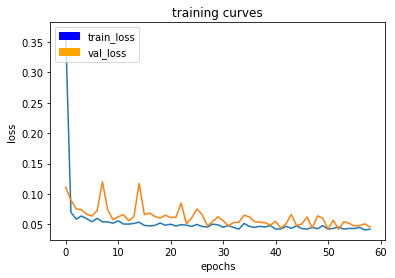

200/200 [==============================] - 44s - loss: 0.0419 - val_loss: 0.0453
Epoch 60/100
199/200 [============================>.] - ETA: 0s - loss: 0.0435

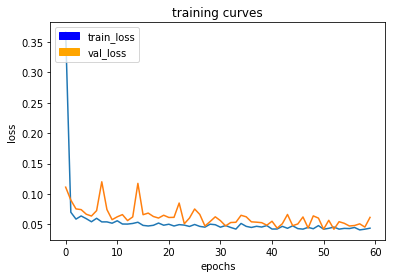

200/200 [==============================] - 45s - loss: 0.0435 - val_loss: 0.0613
Epoch 61/100
199/200 [============================>.] - ETA: 0s - loss: 0.0437

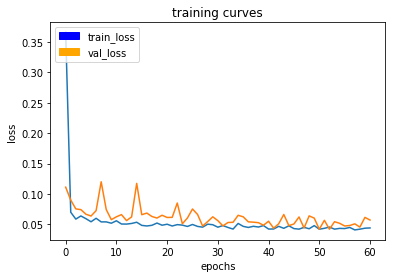

200/200 [==============================] - 44s - loss: 0.0438 - val_loss: 0.0569
Epoch 62/100
199/200 [============================>.] - ETA: 0s - loss: 0.0409

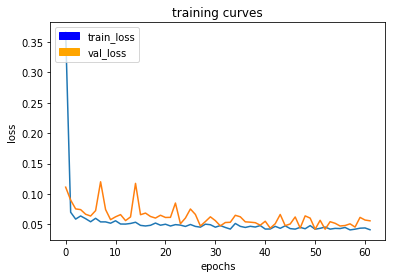

200/200 [==============================] - 44s - loss: 0.0409 - val_loss: 0.0556
Epoch 63/100
199/200 [============================>.] - ETA: 0s - loss: 0.0422

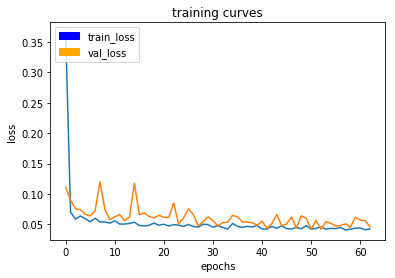

200/200 [==============================] - 44s - loss: 0.0422 - val_loss: 0.0462
Epoch 64/100
199/200 [============================>.] - ETA: 0s - loss: 0.0424

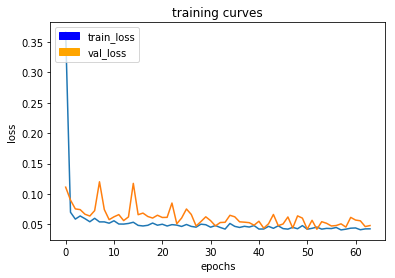

200/200 [==============================] - 44s - loss: 0.0424 - val_loss: 0.0479
Epoch 65/100
199/200 [============================>.] - ETA: 0s - loss: 0.0412

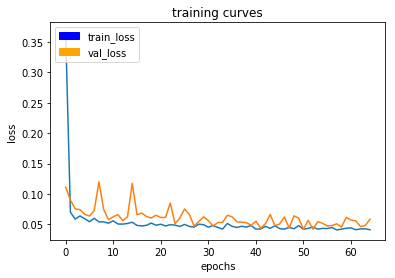

200/200 [==============================] - 44s - loss: 0.0412 - val_loss: 0.0584
Epoch 66/100
199/200 [============================>.] - ETA: 0s - loss: 0.0435

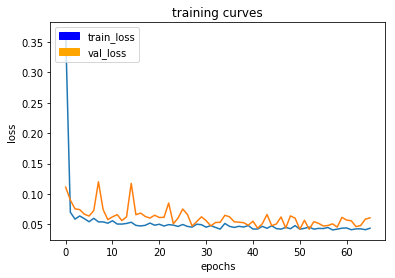

200/200 [==============================] - 44s - loss: 0.0434 - val_loss: 0.0605
Epoch 67/100
199/200 [============================>.] - ETA: 0s - loss: 0.0402

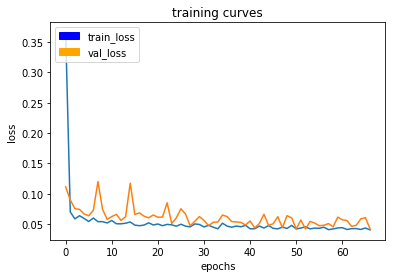

200/200 [==============================] - 44s - loss: 0.0401 - val_loss: 0.0419
Epoch 68/100
199/200 [============================>.] - ETA: 0s - loss: 0.0438

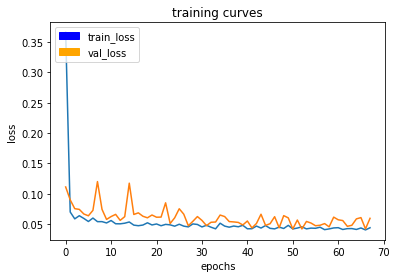

200/200 [==============================] - 44s - loss: 0.0438 - val_loss: 0.0594
Epoch 69/100
199/200 [============================>.] - ETA: 0s - loss: 0.0397

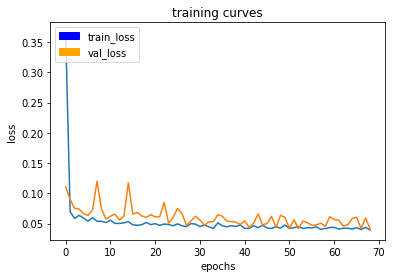

200/200 [==============================] - 44s - loss: 0.0397 - val_loss: 0.0417
Epoch 70/100
199/200 [============================>.] - ETA: 0s - loss: 0.0420

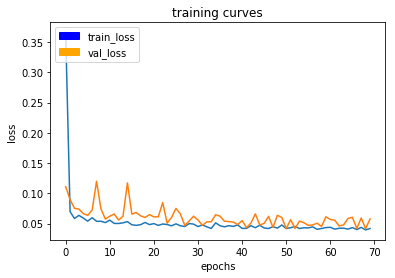

200/200 [==============================] - 44s - loss: 0.0419 - val_loss: 0.0577
Epoch 71/100
199/200 [============================>.] - ETA: 0s - loss: 0.0432

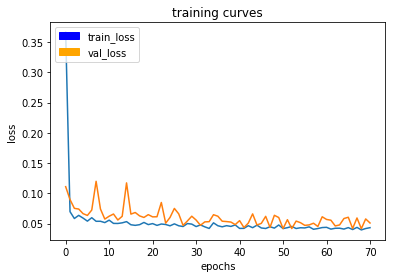

200/200 [==============================] - 44s - loss: 0.0432 - val_loss: 0.0510
Epoch 72/100
199/200 [============================>.] - ETA: 0s - loss: 0.0409

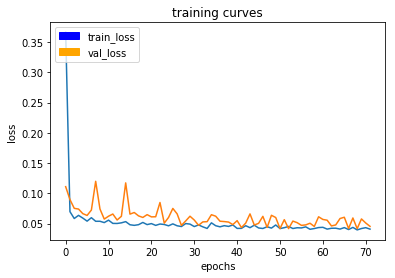

200/200 [==============================] - 44s - loss: 0.0409 - val_loss: 0.0455
Epoch 73/100
199/200 [============================>.] - ETA: 0s - loss: 0.0396

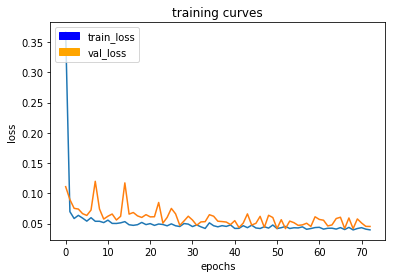

200/200 [==============================] - 44s - loss: 0.0396 - val_loss: 0.0453
Epoch 74/100
199/200 [============================>.] - ETA: 0s - loss: 0.0436

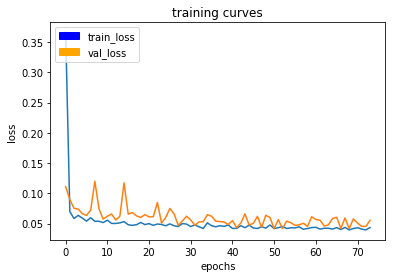

200/200 [==============================] - 44s - loss: 0.0435 - val_loss: 0.0555
Epoch 75/100
199/200 [============================>.] - ETA: 0s - loss: 0.0421

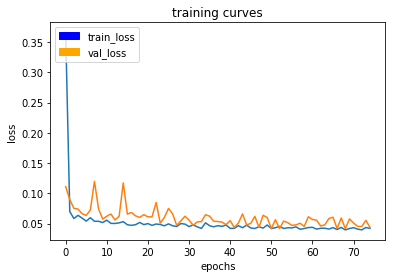

200/200 [==============================] - 44s - loss: 0.0421 - val_loss: 0.0434
Epoch 76/100
199/200 [============================>.] - ETA: 0s - loss: 0.0402

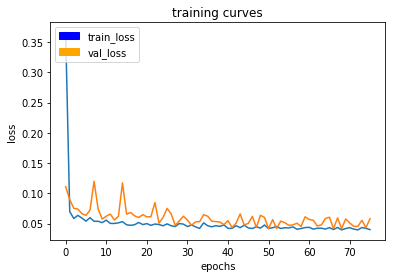

200/200 [==============================] - 44s - loss: 0.0402 - val_loss: 0.0581
Epoch 77/100
199/200 [============================>.] - ETA: 0s - loss: 0.0396

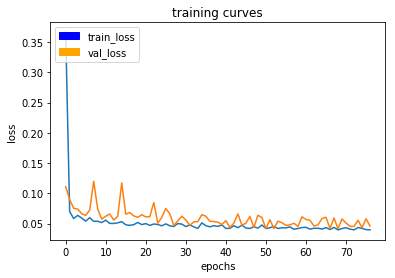

200/200 [==============================] - 44s - loss: 0.0396 - val_loss: 0.0460
Epoch 78/100
199/200 [============================>.] - ETA: 0s - loss: 0.0429

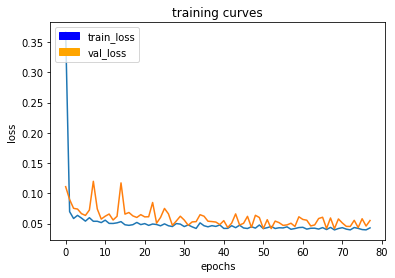

200/200 [==============================] - 44s - loss: 0.0430 - val_loss: 0.0551
Epoch 79/100
199/200 [============================>.] - ETA: 0s - loss: 0.0388

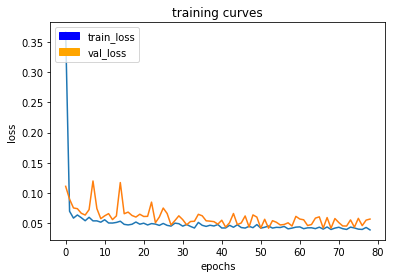

200/200 [==============================] - 44s - loss: 0.0388 - val_loss: 0.0569
Epoch 80/100
199/200 [============================>.] - ETA: 0s - loss: 0.0405

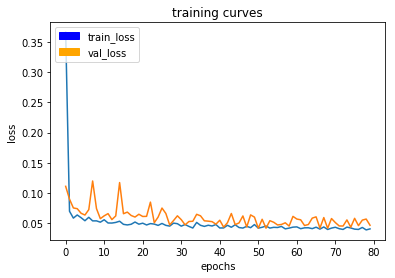

200/200 [==============================] - 44s - loss: 0.0406 - val_loss: 0.0466
Epoch 81/100
199/200 [============================>.] - ETA: 0s - loss: 0.0419

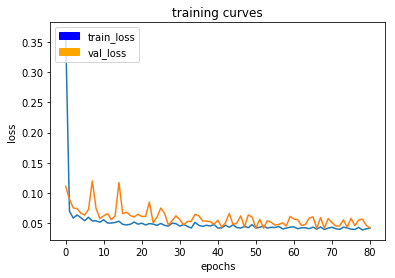

200/200 [==============================] - 44s - loss: 0.0419 - val_loss: 0.0419
Epoch 82/100
199/200 [============================>.] - ETA: 0s - loss: 0.0421

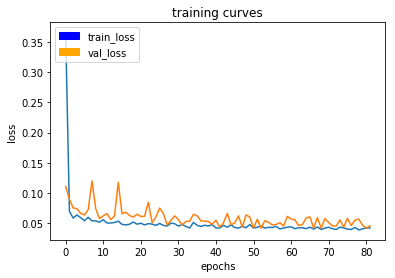

200/200 [==============================] - 44s - loss: 0.0422 - val_loss: 0.0456
Epoch 83/100
199/200 [============================>.] - ETA: 0s - loss: 0.0417

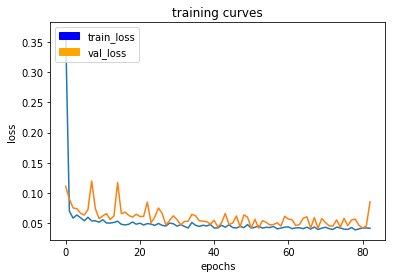

200/200 [==============================] - 44s - loss: 0.0417 - val_loss: 0.0855
Epoch 84/100
199/200 [============================>.] - ETA: 0s - loss: 0.0433

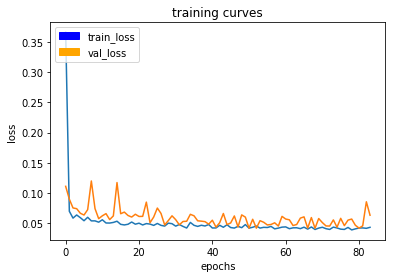

200/200 [==============================] - 44s - loss: 0.0432 - val_loss: 0.0632
Epoch 85/100
199/200 [============================>.] - ETA: 0s - loss: 0.0371

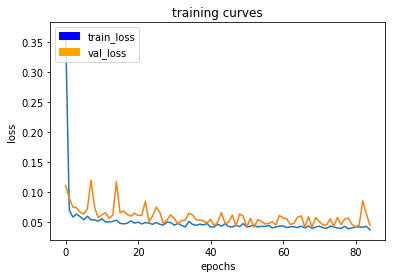

200/200 [==============================] - 44s - loss: 0.0372 - val_loss: 0.0448
Epoch 86/100
199/200 [============================>.] - ETA: 0s - loss: 0.0398

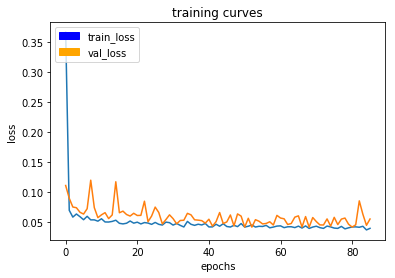

200/200 [==============================] - 44s - loss: 0.0398 - val_loss: 0.0553
Epoch 87/100
199/200 [============================>.] - ETA: 0s - loss: 0.0404

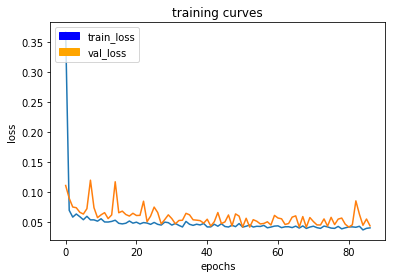

200/200 [==============================] - 44s - loss: 0.0404 - val_loss: 0.0439
Epoch 88/100
199/200 [============================>.] - ETA: 0s - loss: 0.0416

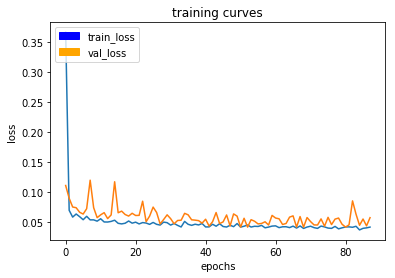

200/200 [==============================] - 44s - loss: 0.0418 - val_loss: 0.0575
Epoch 89/100
199/200 [============================>.] - ETA: 0s - loss: 0.0395

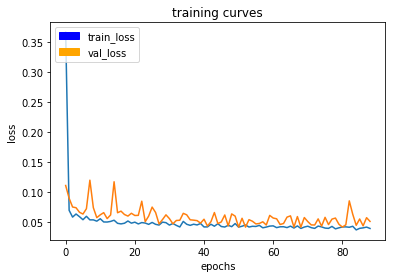

200/200 [==============================] - 44s - loss: 0.0396 - val_loss: 0.0513
Epoch 90/100
199/200 [============================>.] - ETA: 0s - loss: 0.0405

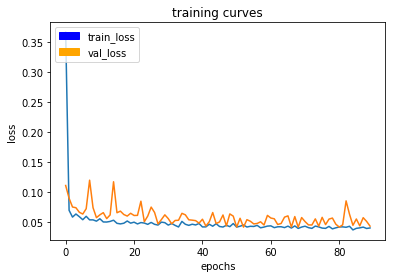

200/200 [==============================] - 44s - loss: 0.0404 - val_loss: 0.0434
Epoch 91/100
199/200 [============================>.] - ETA: 0s - loss: 0.0409

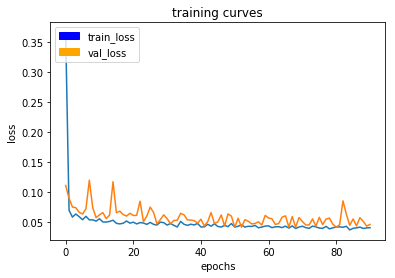

200/200 [==============================] - 44s - loss: 0.0409 - val_loss: 0.0463
Epoch 92/100
199/200 [============================>.] - ETA: 0s - loss: 0.0402

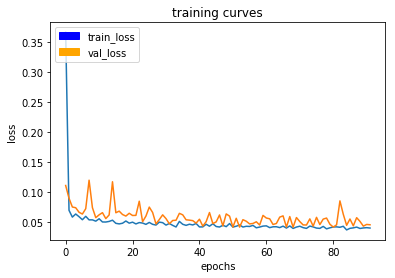

200/200 [==============================] - 44s - loss: 0.0402 - val_loss: 0.0457
Epoch 93/100
199/200 [============================>.] - ETA: 0s - loss: 0.0390

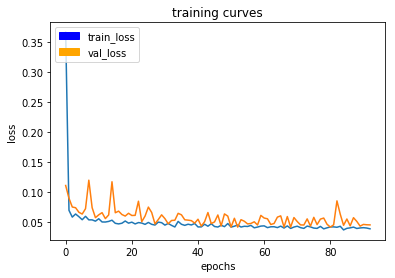

200/200 [==============================] - 44s - loss: 0.0390 - val_loss: 0.0455
Epoch 94/100
199/200 [============================>.] - ETA: 0s - loss: 0.0401

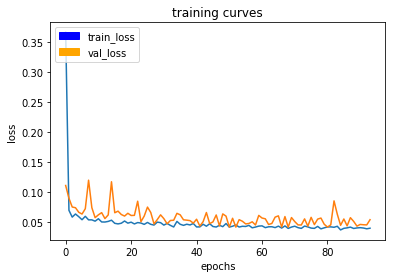

200/200 [==============================] - 44s - loss: 0.0401 - val_loss: 0.0541
Epoch 95/100
199/200 [============================>.] - ETA: 0s - loss: 0.0410

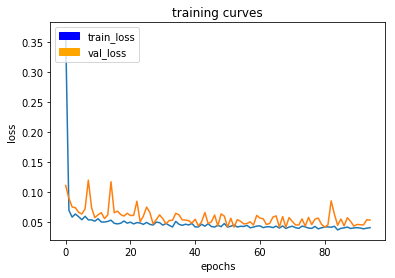

200/200 [==============================] - 44s - loss: 0.0409 - val_loss: 0.0536
Epoch 96/100
199/200 [============================>.] - ETA: 0s - loss: 0.0398

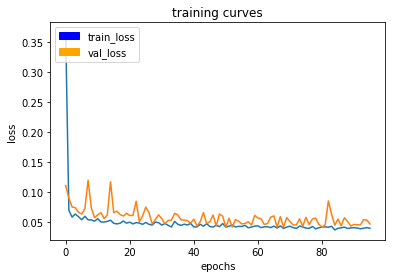

200/200 [==============================] - 44s - loss: 0.0398 - val_loss: 0.0470
Epoch 97/100
199/200 [============================>.] - ETA: 0s - loss: 0.0396

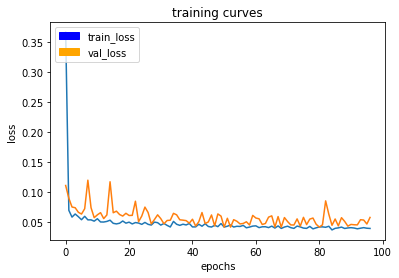

200/200 [==============================] - 44s - loss: 0.0396 - val_loss: 0.0579
Epoch 98/100
199/200 [============================>.] - ETA: 0s - loss: 0.0427

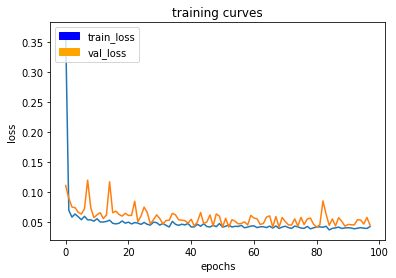

200/200 [==============================] - 44s - loss: 0.0427 - val_loss: 0.0450
Epoch 99/100
199/200 [============================>.] - ETA: 0s - loss: 0.0391

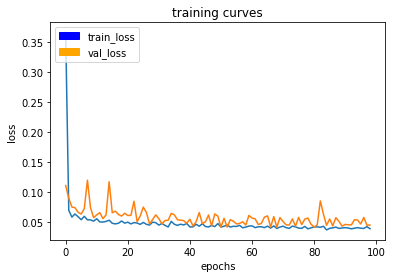

200/200 [==============================] - 44s - loss: 0.0391 - val_loss: 0.0452
Epoch 100/100
199/200 [============================>.] - ETA: 0s - loss: 0.0381

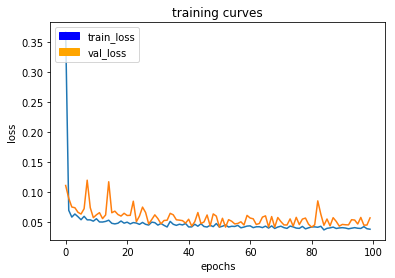

200/200 [==============================] - 44s - loss: 0.0382 - val_loss: 0.0572


In [9]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# Define the Keras model and compile it for training
model = models.Model(inputs=inputs, outputs=output_layer)

model.compile(optimizer=keras.optimizers.Adam(learning_rate), loss='categorical_crossentropy')

# Data iterators for loading the training and validation data
train_iter = data_iterator.BatchIteratorSimple(batch_size=batch_size,
                                               data_folder=os.path.join('..', 'data', 'train'),
                                               image_shape=image_shape,
                                               shift_aug=True)

val_iter = data_iterator.BatchIteratorSimple(batch_size=batch_size,
                                             data_folder=os.path.join('..', 'data', 'validation'),
                                             image_shape=image_shape)

logger_cb = plotting_tools.LoggerPlotter()
callbacks = [logger_cb]

model.fit_generator(train_iter,
                    steps_per_epoch = steps_per_epoch, # the number of batches per epoch,
                    epochs = num_epochs, # the number of epochs to train for,
                    validation_data = val_iter, # validation iterator
                    validation_steps = validation_steps, # the number of batches to validate on
                    callbacks=callbacks,
                    workers = workers)

In [10]:
# Save your trained model weights
weight_file_name = 'model_weights'
model_tools.save_network(model, weight_file_name)

## Prediction <a id='prediction'></a>

Now that you have your model trained and saved, you can make predictions on your validation dataset. These predictions can be compared to the mask images, which are the ground truth labels, to evaluate how well your model is doing under different conditions.

There are three different predictions available from the helper code provided:
- **patrol_with_targ**: Test how well the network can detect the hero from a distance.
- **patrol_non_targ**: Test how often the network makes a mistake and identifies the wrong person as the target.
- **following_images**: Test how well the network can identify the target while following them.

In [11]:
# If you need to load a model which you previously trained you can uncomment the codeline that calls the function below.

# weight_file_name = 'model_weights'
# restored_model = model_tools.load_network(weight_file_name)

The following cell will write predictions to files and return paths to the appropriate directories.
The `run_num` parameter is used to define or group all the data for a particular model run. You can change it for different runs. For example, 'run_1', 'run_2' etc.

In [12]:
run_num = 'run_1'

val_with_targ, pred_with_targ = model_tools.write_predictions_grade_set(model,
                                        run_num,'patrol_with_targ', 'sample_evaluation_data') 

val_no_targ, pred_no_targ = model_tools.write_predictions_grade_set(model, 
                                        run_num,'patrol_non_targ', 'sample_evaluation_data') 

val_following, pred_following = model_tools.write_predictions_grade_set(model,
                                        run_num,'following_images', 'sample_evaluation_data')

Now lets look at your predictions, and compare them to the ground truth labels and original images.
Run each of the following cells to visualize some sample images from the predictions in the validation set.

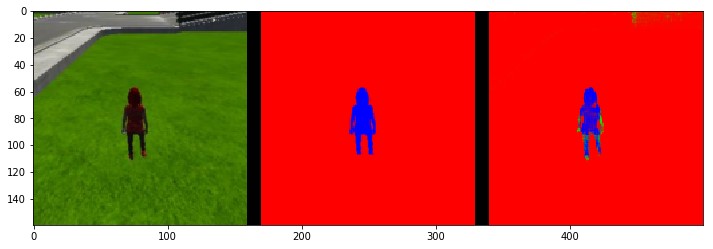

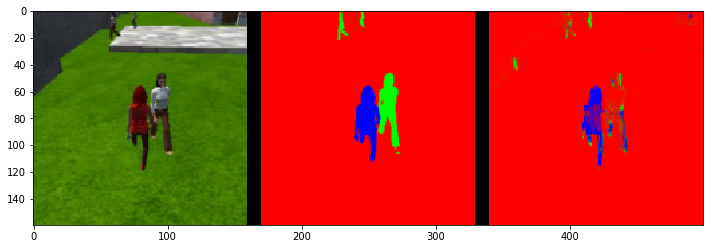

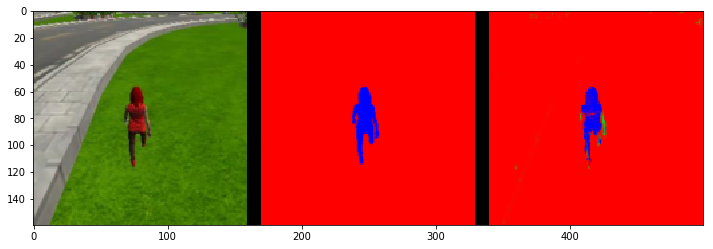

In [13]:
# images while following the target
im_files = plotting_tools.get_im_file_sample('sample_evaluation_data','following_images', run_num) 
for i in range(3):
    im_tuple = plotting_tools.load_images(im_files[i])
    plotting_tools.show_images(im_tuple)
    

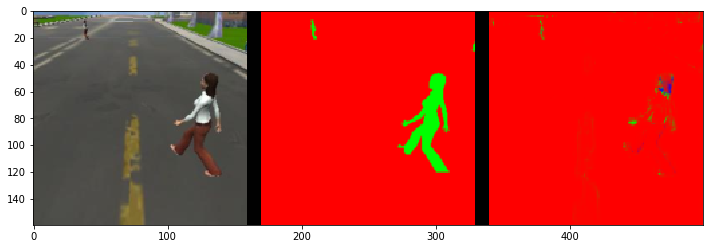

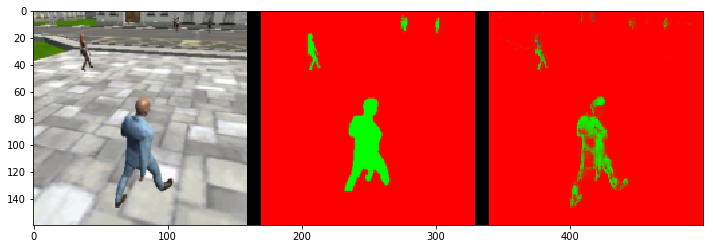

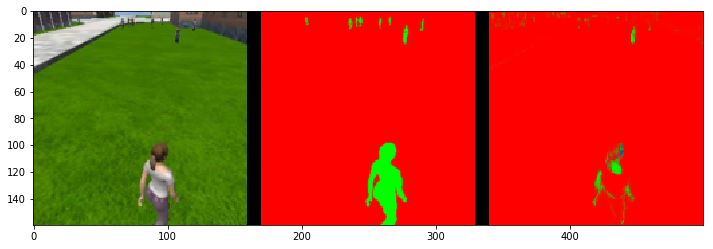

In [14]:
# images while at patrol without target
im_files = plotting_tools.get_im_file_sample('sample_evaluation_data','patrol_non_targ', run_num) 
for i in range(3):
    im_tuple = plotting_tools.load_images(im_files[i])
    plotting_tools.show_images(im_tuple)
 

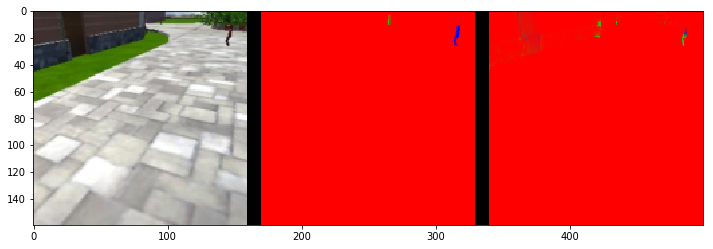

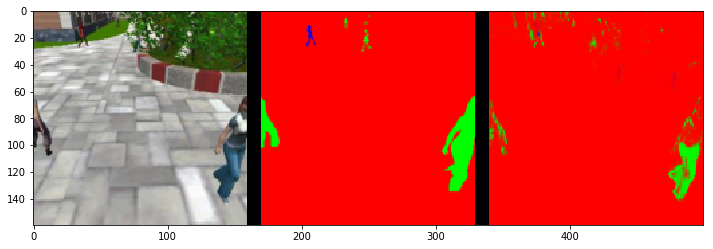

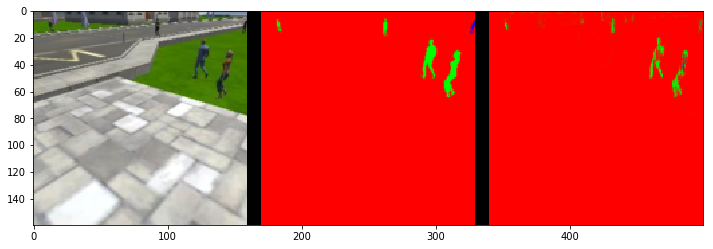

In [15]:
   
# images while at patrol with target
im_files = plotting_tools.get_im_file_sample('sample_evaluation_data','patrol_with_targ', run_num) 
for i in range(3):
    im_tuple = plotting_tools.load_images(im_files[i])
    plotting_tools.show_images(im_tuple)

## Evaluation <a id='evaluation'></a>
Evaluate your model! The following cells include several different scores to help you evaluate your model under the different conditions discussed during the Prediction step. 

In [16]:
# Scores for while the quad is following behind the target. 
true_pos1, false_pos1, false_neg1, iou1 = scoring_utils.score_run_iou(val_following, pred_following)

number of validation samples intersection over the union evaulated on 542
average intersection over union for background is 0.9908235844745987
average intersection over union for other people is 0.17049916157545922
average intersection over union for the hero is 0.7364091231266429
number true positives: 539, number false positives: 0, number false negatives: 0


In [17]:
# Scores for images while the quad is on patrol and the target is not visable
true_pos2, false_pos2, false_neg2, iou2 = scoring_utils.score_run_iou(val_no_targ, pred_no_targ)

number of validation samples intersection over the union evaulated on 270
average intersection over union for background is 0.9698160259475466
average intersection over union for other people is 0.3366900456953615
average intersection over union for the hero is 0.0
number true positives: 0, number false positives: 140, number false negatives: 0


In [18]:
# This score measures how well the neural network can detect the target from far away
true_pos3, false_pos3, false_neg3, iou3 = scoring_utils.score_run_iou(val_with_targ, pred_with_targ)

number of validation samples intersection over the union evaulated on 322
average intersection over union for background is 0.9935603596709122
average intersection over union for other people is 0.2547133560550772
average intersection over union for the hero is 0.12578062074086405
number true positives: 132, number false positives: 2, number false negatives: 169


In [19]:
# Sum all the true positives, etc from the three datasets to get a weight for the score
true_pos = true_pos1 + true_pos2 + true_pos3
false_pos = false_pos1 + false_pos2 + false_pos3
false_neg = false_neg1 + false_neg2 + false_neg3

weight = true_pos/(true_pos+false_neg+false_pos)
print(weight)

0.6832993890020367


In [20]:
# The IoU for the dataset that never includes the hero is excluded from grading
final_IoU = (iou1 + iou3)/2
print(final_IoU)

0.431094871934


In [21]:
# And the final grade score is 
final_score = final_IoU * weight
print(final_score)

0.294566862594
